# Heart Disease UCI - Part 2 (Model Building and Interpretation)

Hello Kagglers!

This notebook is the Part 2 (and final part) of the series of notebooks on Heart Disease UCI dataset. While the first part dealt with exploratory data analysis and getting insights from the visualisations, this part deals explicitly with the model building part of it and interpreting the built model using a lot of useful python libraries.

So get ready for another dose of visualisations post building the model on this dataset.

In case you missed to check out the Part 1 of this series, feel free to click the link below:
https://www.kaggle.com/shrijan19/heart-disease-part-1-eda


In [1]:
#Importing the necessary libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
warnings.filterwarnings("ignore")

In [2]:
#Read the dataset from the path and see a preview of it
df = pd.read_csv("/kaggle/input/heart-disease-uci/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In the part-I of this kernel, we saw that some features were working better after binning them into different categories. That is the below mentioned features can be transformed from Continuous random variable(RV) to Categorical RV:

1. Age 
2. Resting Blood Pressure
3. Cholestrol

**Converting some of the Continuous RVs to Categorical RVs**

In [3]:
#Creating bins for age
lstBins = [20,40,50,60,70,90]
df["ageGrp"] = pd.cut(df["age"], bins = lstBins, labels = ["Young", "Young2Old", "Old", "Senior", "Fragile"])

#Binning the rest systolic BP
bpCatLst = [70,100,120,140,160,220]
df["bpGrp"] = pd.cut(df["trestbps"], bins = bpCatLst, labels = ["very low", "low", "normal","high","very high"])

#Binning the cholestrol levels
cholCatLst = [100,200,239,300,350,700]
df["cholGrp"] = pd.cut(df["chol"], bins = cholCatLst, labels = ["normal", "borderline high", "high","very high","risky high"])

Applying **One hot Encoding** to these newly created **grouped** columns

In [4]:
#Creating a list of columns for which dummy variables will be created
colLst = ["ageGrp", "bpGrp", "cholGrp"]

#Iterating in the column list to create dummy variables
for col in colLst:
    
    dfTemp = pd.get_dummies(df[col], prefix = col, drop_first=True)
    
    #Merging the dummy variables with existing variables
    df = pd.concat([df,dfTemp] , axis = 1, join = "inner")


**Deleting the existing Continuous RV columns corresponding to the newly created Categorical RV columns**

In [5]:
#Dropping the columns
df.drop(columns = ["age", "trestbps", "chol", "ageGrp", "bpGrp", "cholGrp"], inplace = True)

**Splitting the data into training set and testing set**

In [6]:
y = df["target"].copy()
X = df.drop(columns = ["target"]).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

**Implementing a random forest based model on this data set and checking its accuracy**

# Random Forest Model

In [7]:
model_RF = RandomForestClassifier(n_estimators=200, random_state=42, max_depth = 2, n_jobs = -1)
model_RF.fit(X_train, y_train)
model_RF.score(X_test, y_test)

0.8571428571428571

AUC = 0.9034146341463415


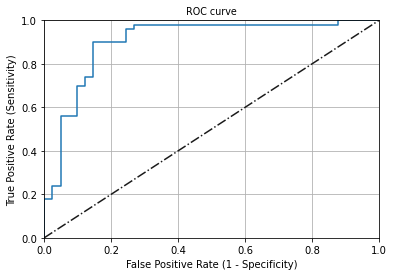

In [8]:
#Plotting the ROC curve for our model
y_pred = model_RF.predict(X_test)
y_pred_prob = model_RF.predict_proba(X_test)[:, 1]

#Printing the AUC value for the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
print("AUC = " + str(auc(fpr, tpr)))

#ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="-.", c=".1")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 8
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Model Interpretation

In this section of the notebook, we will be delving into the post model building tasks. As you must be aware, model building is one aspect of solving any data science problem and the other equally important aspect is to be able to get inferences from your built model so that your model is explainable to others.

Hence, we must gather insights from our built model that complement the predictions or classifications of our model.

# Permutation Importance

Lets begin by checking what are the most important features that are causing a heart disease. We will be using the Permutation Importance method to check for the features that are most significant for our model.


I would highly recommend to go through this excellent article on Permutation Importance from the below link:
https://www.kaggle.com/dansbecker/permutation-importance

In [9]:
#Getting the order of importance of the features in the model
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_RF, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Using TensorFlow backend.


Weight,Feature
0.0505 ± 0.0298,thal
0.0462 ± 0.0164,cp
0.0418 ± 0.0323,ca
0.0220 ± 0.0461,oldpeak
0.0132 ± 0.0292,slope
0.0110 ± 0.0000,sex
0.0044 ± 0.0108,ageGrp_Young2Old
0 ± 0.0000,fbs
0 ± 0.0000,cholGrp_high
0 ± 0.0000,cholGrp_borderline high


As evident from the figure above, the 5 most import features that determine if a person has heart disease or not are:
1. **Thal**
2. Chest Pain (**CP**)
3. Number of coloured arteries in flouroscopy (**CA**)
4. Old Peak in the ECG (**oldpeak**)
5. Slope of ST depression in the ECG (**slope**)

The permutation importance graph gives a very broad level picture of what are the prime factors that are causing a heart disease. However, this plot fails to give out any further information.

For example, if I am interested in knowing how much is the contribution or how exactly is Chest Pain causing a heart disease then the Permutation Importance is not able to answer such questions. In order to see how a particular variable is exactly affecting the model's output, we need to plot **Partial Dependence Plots**.

# Partial Dependence Plots

Let us try to understand the working of Partial dependence plot using an example. In the below code, we will try to see how the feature **chest pain** affects the change in prediction of heart disease.

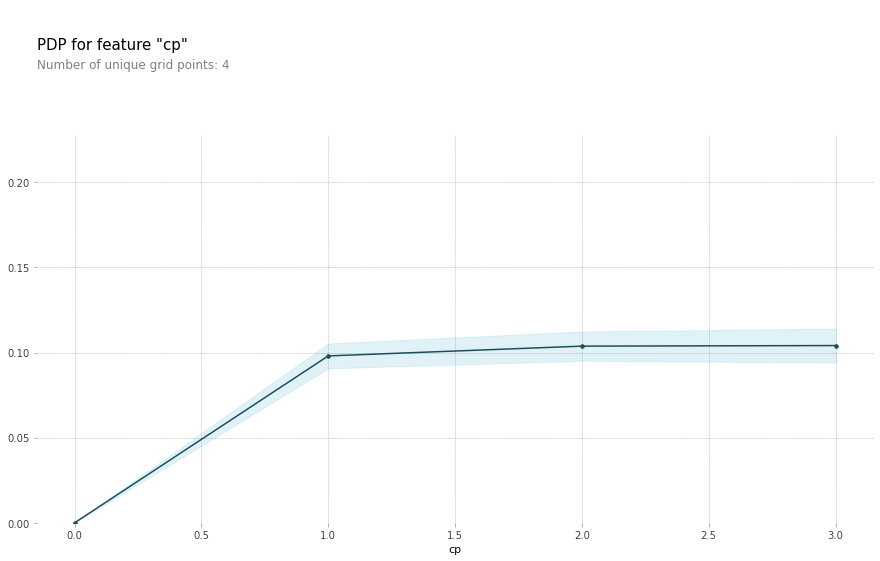

In [10]:
#Importing packages for constructing the Partial Dependence Plot
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_thal = pdp.pdp_isolate(model=model_RF, dataset=X_test, model_features=X_test.columns, feature='cp')

# plot it
pdp.pdp_plot(pdp_thal, 'cp')
plt.show()


The x-axis in the above graph are different levels of the chest pain and the y-aixs is the change in prediction of the target variable.

**The above PDP (Partial dependence plot) shows that increasing the chest pain from level 0 to level 1, increase the chances of heart disease by 0.1**. However, increasing the chest pain further from level 1 to level 2 does not significantly increase the chance of the heart disease.

You can similarly obtain PDP of other important features and see what your model thinks how a particular feature affects the target variable.

# 2 Variable Partial Dependence Plot

While it is important to check how a single variable affects the target variable, it sometimes is equally important to know how a combination of 2 variables simulataneously affect the model's output. And to our relief, we have 2 variable partial dependence plots which does exactly that.

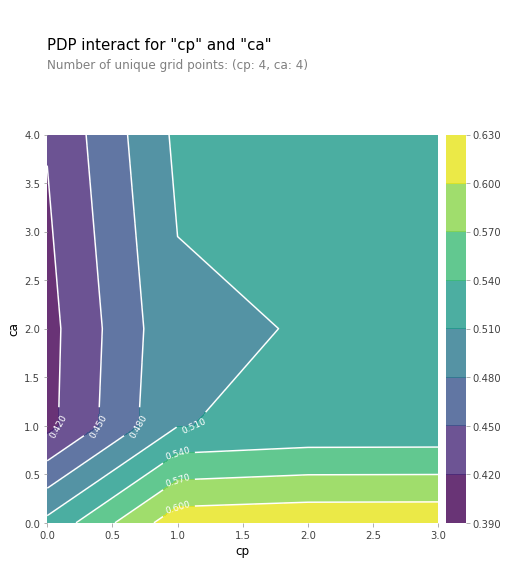

In [11]:
# 2 variable PDP of Chest Pain and Coloured Arteries
features_to_plot = ['cp', 'ca']
inter1  =  pdp.pdp_interact(model=model_RF, dataset=X_test, model_features=X_test.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

**Can you interpret the above interesting plot?**

Let me help you out. Lets focus on the yellow region first. The region has a target probability of 0.60. The yellow region is made up of points with **cp >= 1 and number of coloured arteries (ca) approximately = 0.**

This means that a person with chest pain type >=1 and number of coloured arteries in flouroscopy close to 0 has a 0.6 chance of developing a heart disease. And guess what, this makes perfect sense. The number of coloured arteries in a person basically shows the blockage in the arteries. A person with total blockage in major arteries will have ca=0 and a person with no blockage in major arteries will have a high value for ca. And since major blockages will definitely result in heart ailments hence, the probability of 0.6 makes sense.

# Concluding Remarks

I hope the readers understand that the objective of this kernel was not to construct a highly efficient model with the best hyperparameters. Rather, the objective was to open the window to post model inferences that can be drawn from the model. I hope this kernel introduced you to simple yet powerful methods of checking the most significant features as determined by the model and how the features individually and collectively affect the output of the model.

Thanks for going through this kernel. Feel free to post your doubts and suggestions in the comments section and I will happy to respond to each and every one.